# [Estimation of Obesity Levels Based On Eating Habits and Physical Condition](https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition)

This dataset include data for the estimation of obesity levels in individuals from the countries of Mexico, Peru and Colombia, based on their eating habits and physical condition.

### Estrutura do dataset

| Alvo  | Valores |
| ------------- | ------------- |
|NObeyesdad| {Insufficient Weight, Normal Weight, Overweight Level I, Overweight Level II, Obesity Type I, Obesity Type II, Obesity Type III}| 

| Features  | Tipo |
| ------------- | ------------- |
|Gender|Categorical|
|Age|Continuous|
|Height|Continuous|
|Weight|Continuous|
|family_history_with_overweight|Binary|
|FAVC|Binary|
|FCVC|Integer|
|NCP|Continuous|
|CAEC|Categorical|
|SMOKE|Binary|
|CH2O|Continuous|
|SCC|Binary|
|FAF|Continuous|
|TUE|Integer|
|CALC|Categorical|
|MTRANS|Categorical|

### Instalação das dependências

In [61]:
import pandas as pd

from sklearn.model_selection import train_test_split

from ucimlrepo import fetch_ucirepo 
pd.options.mode.copy_on_write = True

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import torch
import torch.nn as nn
import torchmetrics

import torchhd
from torchhd.models import  IntRVFL
from torchhd import embeddings

# Use the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using {} device".format(device))

DIMENSIONS = 10000
NUM_LEVELS = 100
HIDDEN_LAYERS = 45 # O aumento de hidden layers pode gerar problemas de performance.
BATCH_SIZE = 1 

Using cpu device


### Importando o dataset

In [62]:
# fetch dataset 
dataset = fetch_ucirepo(id=544) 
  
# data (as pandas dataframes) 
X = dataset.data.features 
Y = dataset.data.targets 

# Transform labels to int
target_class = 'NObeyesdad'

labels = Y[target_class].unique()
for i in range(len(labels)):
  Y.loc[Y[target_class]==labels[i], target_class] = i

### One-hot Encoding das features

In [63]:
cat_features = []
num_features = []
for feature in dataset.data.features:
    feature_info = dataset.variables.loc[dataset.variables["name"] == feature]
    if feature_info.type.values[0] == "Categorical":
        cat_features.append(feature)
    else:
        if feature_info.type.values[0] == "Binary":
            values = X[feature].unique()
            for i in range(len(values)):
                X.loc[X[feature]==values[i], feature] = 2*i -1

        X[feature] = X[feature].astype(float) # Transforma em float caso seja str
        num_features.append(feature)

In [64]:
X = pd.get_dummies(X,columns=cat_features, dtype=int)

### Dividindo os conjuntos de teste e treino

In [65]:
x_train, x_test, y_train, y_test = train_test_split(X, Y,test_size= 0.3, random_state = 28)
y_true = list(y_test[target_class])

y_train= y_train.astype(int)
y_test= y_test.astype(int)

num_classes = len(labels)
num_features = len(x_train.columns)


### HDC

Classificação utilizando o modelo IntRVFL implementado pelo torchhd.

Os modelos e encoders foram feitos a partir de adaptações do código do [exemplo apresentado na documentação do torchhd ](https://torchhd.readthedocs.io/en/stable/classification.html)

#### Record-based enconding dos dados

In [66]:
class RecordEncoder(nn.Module):
        def __init__(self, out_features, size, levels):
                super(RecordEncoder, self).__init__()
                self.position = embeddings.Random(size, out_features)
                self.value = embeddings.Level(levels, out_features)

        def forward(self, x):
                sample_hv = torchhd.bind(self.position.weight, self.value(x)) # Bind da posicao com os valores dos hipervetores
                sample_hv = torchhd.multiset(sample_hv) # Bundle de todos os hipervetores
                return torchhd.hard_quantize(sample_hv)

record_encode = RecordEncoder(DIMENSIONS, num_features, NUM_LEVELS)
record_encode = record_encode.to(device)


record_model = IntRVFL(DIMENSIONS, HIDDEN_LAYERS, num_classes)
record_model = record_model.to(device)

#### Treinamento

In [67]:
with torch.no_grad():
                samples = torch.tensor(x_train.values).to(device)
                labels = torch.tensor(y_train.values).squeeze().to(device)

                """ Treinamento record-based"""
                samples_hv = record_encode(samples)
                record_model.fit_ridge_regression(samples_hv, labels)

#### Teste

In [68]:
record_accuracy = torchmetrics.Accuracy("multiclass", num_classes=num_classes)

with torch.no_grad():
        samples = torch.tensor(x_test.values).to(device)
        labels = torch.tensor(y_test.values).squeeze().to(device)

        """ Testes record-based"""
        samples_hv = record_encode(samples)
        outputs = record_model(samples_hv)
        record_accuracy.update(outputs.cpu(), labels)

record_acc = round((record_accuracy.compute().item() * 100), 2)
print(f"Acuracia obtida por record-based encoding: {record_acc}%")

Acuracia obtida por record-based encoding: 51.42%


#### N-gram based enconding dos dados

In [69]:
class NGramEncoder(nn.Module):
        def __init__(self, out_features, size, levels,n=3):
                super(NGramEncoder, self).__init__()
                self.position = embeddings.Random(size, out_features)
                self.value = embeddings.Level(levels, out_features)
                self.n = n

        def forward(self, x):
                sample_hv = torchhd.bind(self.position.weight, self.value(x)) # Bind da posicao com os valores dos hipervetores
                sample_hv = torchhd.ngrams(sample_hv,self.n) # n-gram dos hipervetores
                return torchhd.hard_quantize(sample_hv)

n_gram_encode = NGramEncoder(DIMENSIONS, num_features, NUM_LEVELS)
n_gram_encode = n_gram_encode.to(device)

n_gram_model = IntRVFL(DIMENSIONS, HIDDEN_LAYERS, num_classes)
n_gram_model = n_gram_model.to(device)

#### Treinamento

In [70]:
with torch.no_grad():
                samples = torch.tensor(x_train.values).to(device)
                labels = torch.tensor(y_train.values).squeeze().to(device)

                """ Treinamento n-gram based"""
                samples_hv = n_gram_encode(samples)
                n_gram_model.fit_ridge_regression(samples_hv, labels)

#### Teste

In [71]:
n_gram_accuracy = torchmetrics.Accuracy("multiclass", num_classes=num_classes)

with torch.no_grad():
        samples = torch.tensor(x_test.values).to(device)
        labels = torch.tensor(y_test.values).squeeze().to(device)

        """ Testes n-gram based"""
        samples_hv = n_gram_encode(samples)
        outputs = n_gram_model(samples_hv)
        n_gram_accuracy.update(outputs.cpu(), labels)

n_gram_acc = round((n_gram_accuracy.compute().item() * 100), 2)
print(f"Acuracia obtida por n-gram based encoding: {n_gram_acc}%")

Acuracia obtida por n-gram based encoding: 56.15%


### Comparação entre codificações

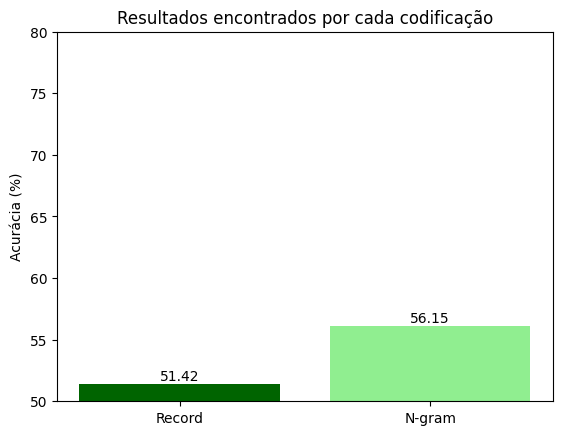

In [72]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

encodings = ['Record', 'N-gram']
counts = [record_acc, n_gram_acc]
bar_colors = ['darkgreen', 'lightgreen']

bar = ax.bar(encodings, counts, color=bar_colors)

ax.set_ylabel('Acurácia (%)')
ax.set_title('Resultados encontrados por cada codificação')
ax.set_ylim(50, 80)
ax.bar_label(bar, fmt='{:,.2f}')
plt.show()